In [1]:
# 定数
band_colors = ['blue', 'green', 'red', 'orange', 'yellow', 'gray']
band_names = ['u', 'g', 'r', 'i', 'z', 'Y']
classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
band_center = [350, 500, 600, 750, 875, 1000]


In [2]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import lightgbm as lgb
import logging
import time

from sklearn.metrics import confusion_matrix
import cesium.featurize as featurize
import sncosmo
import astropy
import iminuit

import warnings
warnings.filterwarnings("ignore")

In [4]:
tr = pd.read_pickle('../data/test.pkl')
tr_log = pd.read_pickle('../data/test_log00.pkl')
tr_log = pd.merge(tr_log, tr[['object_id', 'hostgal_photoz',]], on='object_id', how='left')
tr_log['mjd_photoz'] = tr_log['mjd'] / (1 + tr_log.hostgal_photoz)

In [5]:
idxmax = tr_log.groupby('object_id').flux.transform('idxmax')
idxmax = tr_log.groupby('object_id').flux.transform('idxmax')
tr_log['after_peak'] = (tr_log.index > idxmax) & (tr_log.index < (idxmax+60))

In [6]:
tr_log.flux -= tr_log.groupby(['object_id']).flux.transform('min')
tr_log.flux /= tr_log.groupby('object_id').flux.transform('max')

In [7]:
idxmax = tr_log.groupby('object_id').flux.idxmax()
tbl = tr_log.iloc[idxmax].reset_index(drop=True)
tbl['date_start'] = tbl['date'] - 10
tbl['date_end'] = tbl['date'] + 60
tr_log = pd.merge(tr_log, tbl[['object_id', 'date_start', 'date_end']], how='left', on='object_id')
tr_log['target_date'] = (tr_log.date_start <= tr_log.date) & (tr_log.date <= tr_log.date_end) 

In [8]:
oids = tr_log[tr_log.date.between(tr_log.date_start, tr_log.date_start+9)]['object_id'].tolist()

In [9]:
tr_log = tr_log[tr_log.object_id.isin(oids)].reset_index(drop=True)

In [9]:
# idxmax = tr_log.groupby('object_id').flux.idxmax()
# base = tr_log.iloc[idxmax][['object_id', 'date']]
# li = [base]
# for i in range(10):
#     i += 1
#     lead = base.copy()
#     lead['date'] += i
#     lag = base.copy()
#     lag['date'] -= i
#     li.append(lead)
#     li.append(lag)

# keep = pd.concat(li)

# tr_log = pd.merge(keep, tr_log, on=['object_id', 'date'], how='left')

# tr_log.date -= tr_log.groupby('object_id').date.transform('min')

In [13]:
tr_log.object_id.unique()

array([     1100,      1600,      3500, ..., 104835300, 104837800,
       104848900])

In [23]:
def plt_obj(df, ax=None, title=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(12, 4))
    for pb,(bc, bn) in enumerate(zip(band_colors, band_names)):
        times = df[df.passband==pb].mjd
        selected_flux = df[df.passband==pb].flux
        selected_err = df[df.passband==pb].flux_err
        ax.scatter(x=times, 
                           y=selected_flux, 
                           c=bc,
                          label=bn,
                           s=20)
        if title is not None:
            ax.set_title(title)
#         ax.vlines(times, 
#                           selected_flux-selected_err,
#                           selected_flux+selected_err,
#                       alpha=0.5,
#                       linewidth=0.5)

def plt2(oid):
    f, ax = plt.subplots(1, 3, figsize=(14, 4))
    tmp = tr_log[tr_log.object_id==oid]
    plt_obj(tmp, ax=ax[0], title='ALL')
    
    photoz = tmp.hostgal_photoz.values[0]
    ddf = tr[tr.object_id==oid].ddf.values[0]
    f.suptitle(f'oid: {oid}    ddf: {ddf}    photoz: {photoz}')
    
    tmp = tr_log[(tr_log.object_id==oid) & (tr_log.target_date==True)]
    plt_obj(tmp, ax=ax[1], title='10 ~ peak ~ 60')
    
    
    tmp = tr_log[(tr_log.object_id==oid) & (tr_log.target_date==True) & (tr_log.detected==1)]
    plt_obj(tmp, ax=ax[2], title='detected=1')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [24]:
oids = tr[tr.object_id.isin(tr_log.object_id)].object_id.tolist()

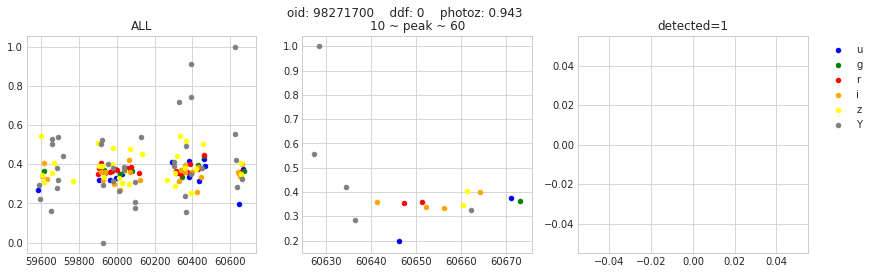

In [29]:
plt2(np.random.choice(oids))

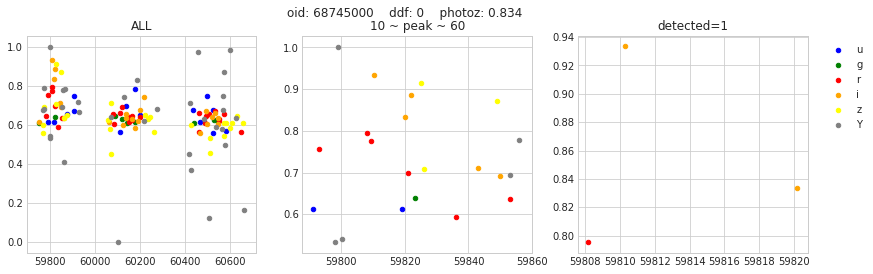

In [30]:
plt2(np.random.choice(oids))

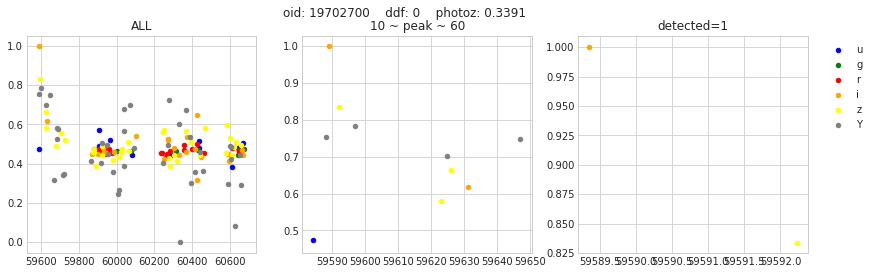

In [31]:
plt2(np.random.choice(oids))

In [26]:
tr_log[tr_log.object_id==4132][['date', 'date_start']]

,date,date_start


# class 42

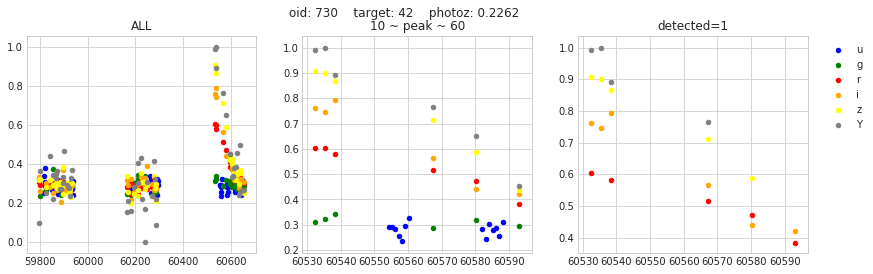

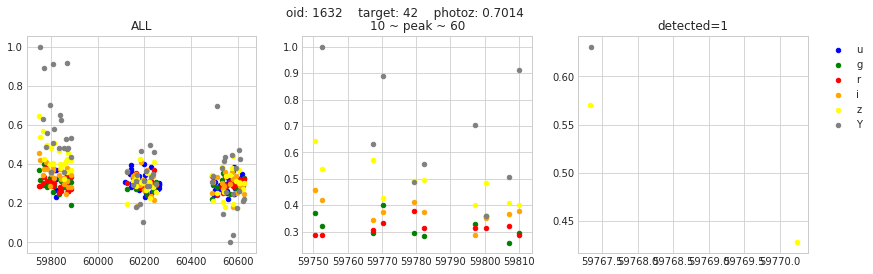

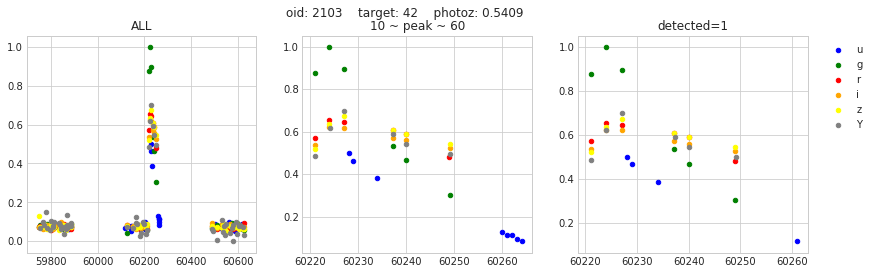

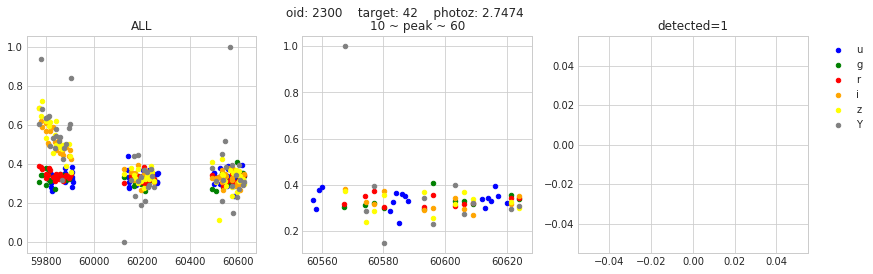

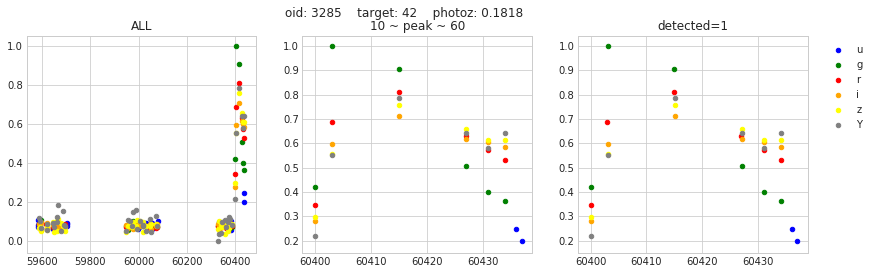

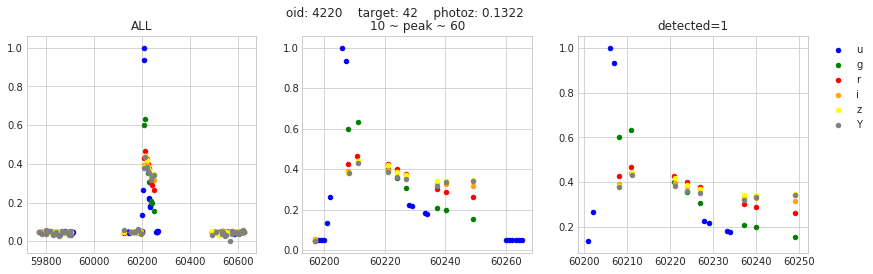

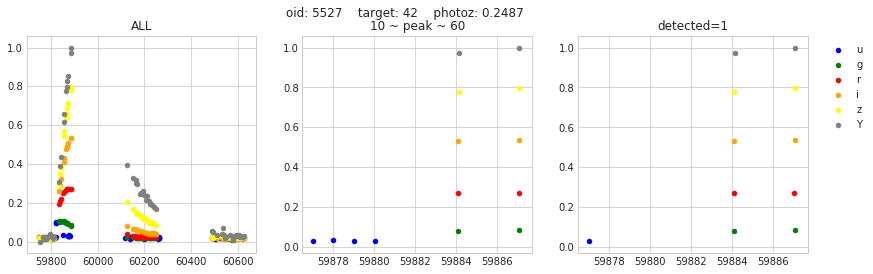

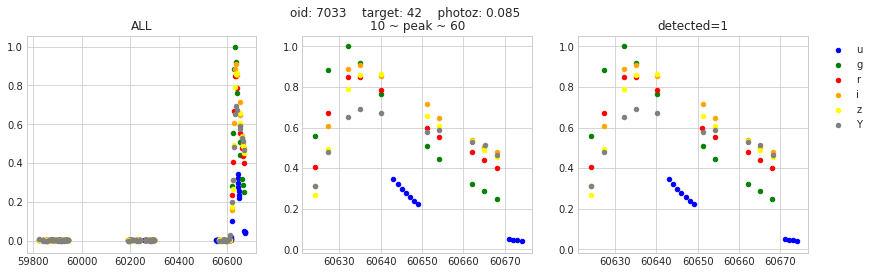

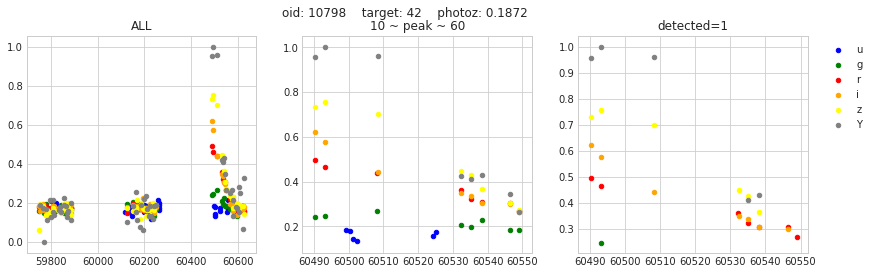

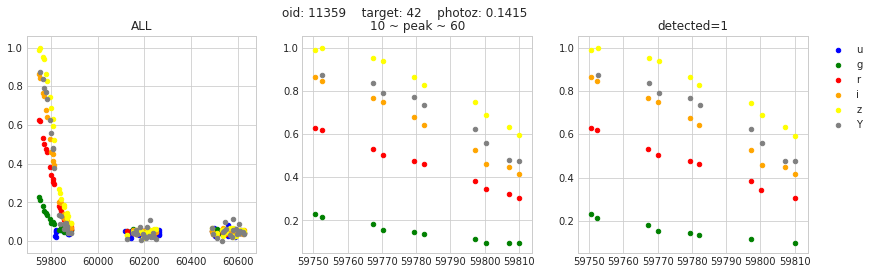

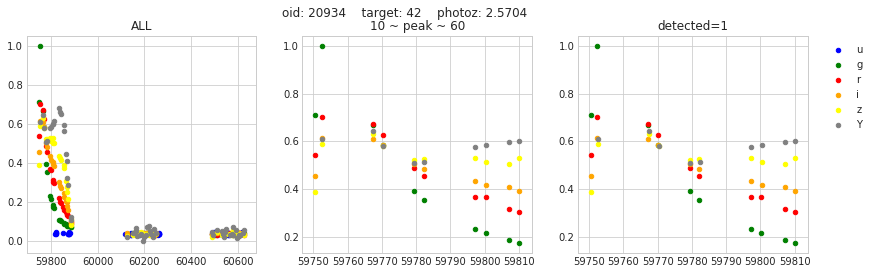

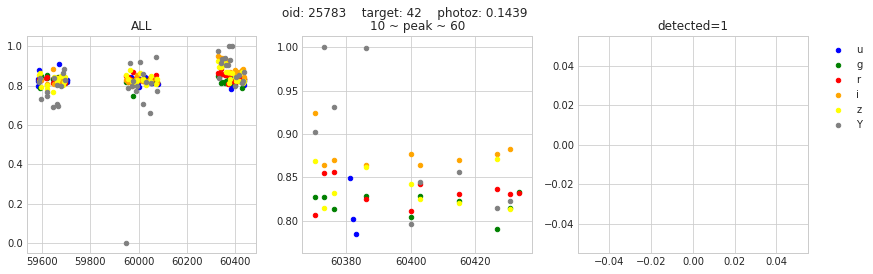

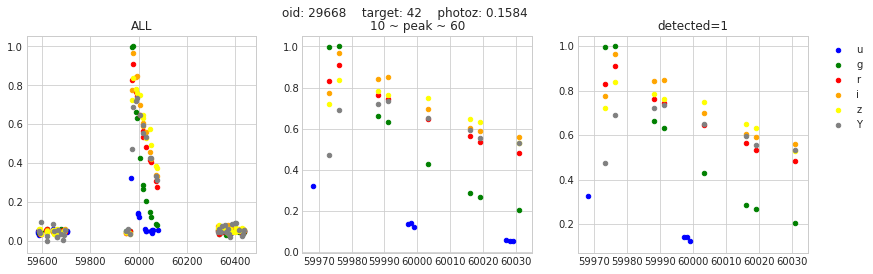

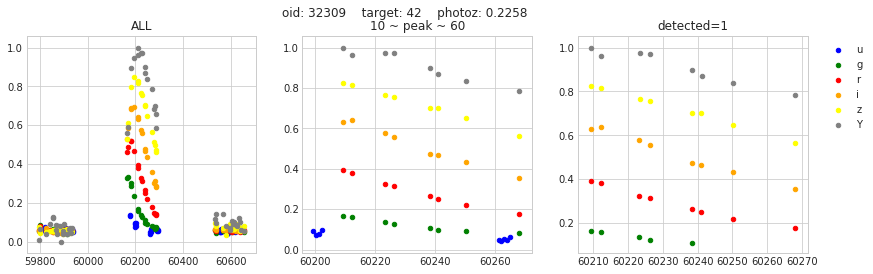

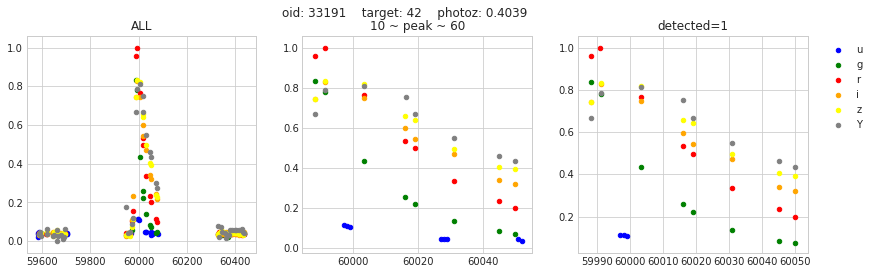

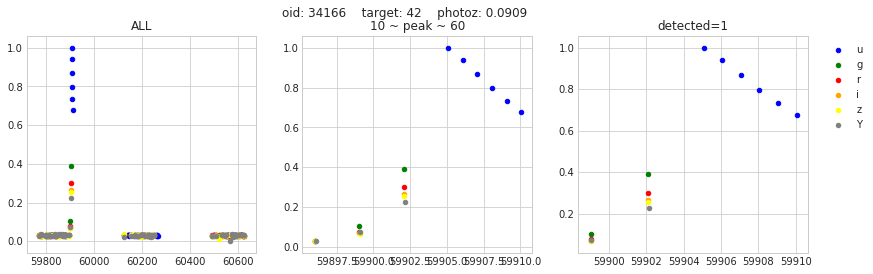

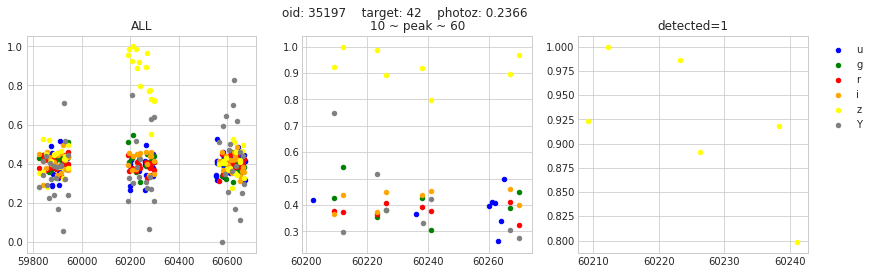

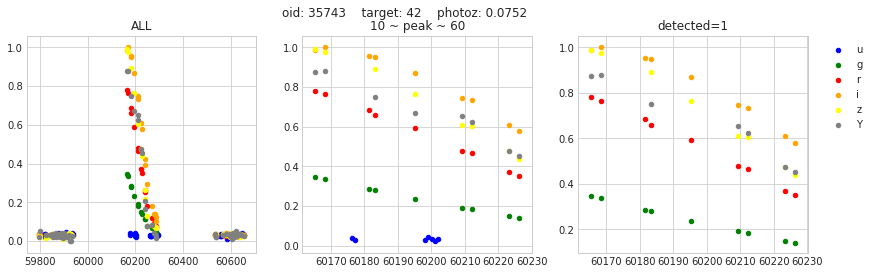

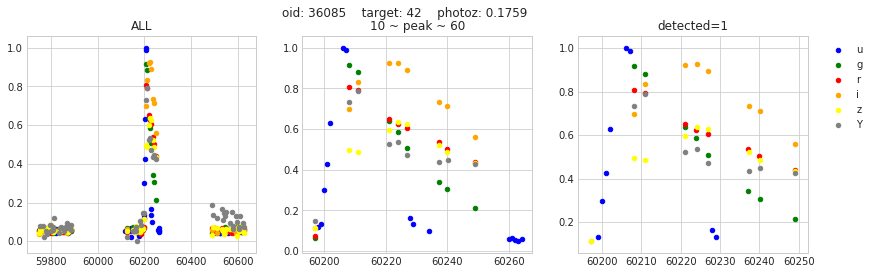

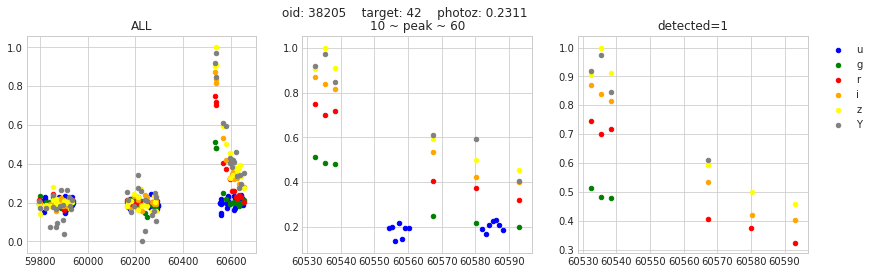

In [27]:
oids = tr_log[tr_log.target==42].object_id.unique()
for oid in oids[:20]:
    plt2(oid)

# class 52

In [ ]:
oids = tr_log[tr_log.target==52].object_id.unique()
for oid in oids[:20]:
    plt2(oid)

# class 62

In [ ]:
oids = df[df.target==62].object_id.unique()
for oid in oids[:20]:
    plt2(oid)

# class 67

In [ ]:
oids = df[df.target==67].object_id.unique()
for oid in oids[:20]:
    plt2(oid)

In [10]:
def plt_temp(class_):
    tmp = tr_log[(tr_log.target==class_) & (tr_log.target_date==True)]
    tmp.mjd -= tmp.groupby('object_id').mjd.transform('min')
    tmp.date = tmp.mjd.astype(int)

#     pd.pivot_table(tmp, index=['date'], columns=['passband'], values=['flux'], aggfunc='std').plot()
    pd.pivot_table(tmp, index=['date'], columns=['passband'], values=['flux'], aggfunc='mean').plot()
    plt.legend(band_names, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'class {class_}')

(None, None, None, None, None)

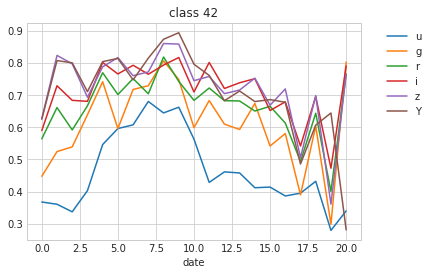

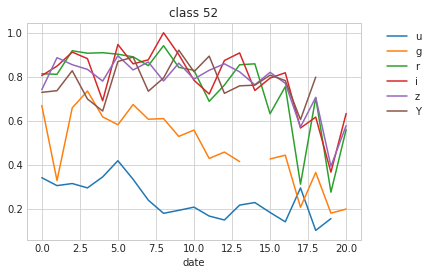

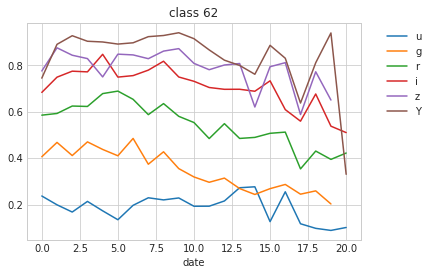

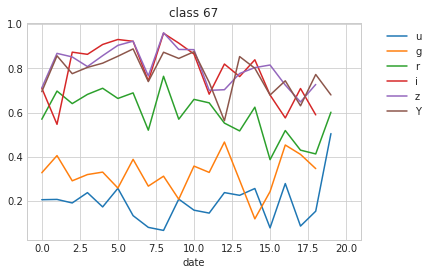

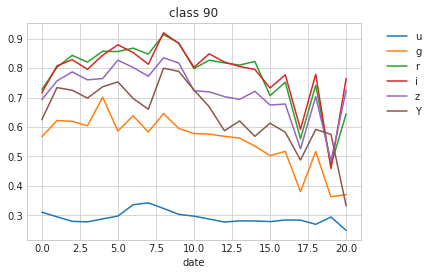

In [11]:
plt_temp(42), plt_temp(52), plt_temp(62), plt_temp(67), plt_temp(90)

In [ ]:
tr.target.value_counts()

In [11]:
DAYS_FROM = 10
DAYS_TO = 10


class_SN = [42, 52, 62, 67, 90]

tr = pd.read_pickle('../data/train.pkl')


tr_log = pd.read_pickle('../data/train_log.pkl')
tr_log = pd.merge(tr_log, tr[['object_id', 'hostgal_photoz', 'target']], 
                  on='object_id', how='left')
tr_log = tr_log[(tr_log.target.isin(class_SN))].reset_index(drop=True)


# -DAYS_FROM ~ peak + DAYS_TO
idxmax = tr_log.groupby('object_id').flux.idxmax()
base = tr_log.iloc[idxmax][['object_id', 'date']]
li = []
for i in range(-DAYS_FROM, 0):
    tmp = base.copy()
    tmp['date'] += i
    li.append(tmp)

lag = pd.concat(li)
lag = pd.merge(lag, tr_log, on=['object_id', 'date'], how='left')
lag = lag.sort_values(['object_id', 'date']).reset_index(drop=True)

li = []
for i in range(0, DAYS_TO):
    tmp = base.copy()
    tmp['date'] += i
    li.append(tmp)

lead = pd.concat(li)
lead = pd.merge(lead, tr_log, on=['object_id', 'date'], how='left')
lead = lead[lead.object_id.isin(lag.object_id)].sort_values(['object_id', 'date']).reset_index(drop=True)

tr_log = pd.concat([lag, lead], ignore_index=True).sort_values(['object_id', 'date']).reset_index(drop=True)

def norm_flux_date(df):
#    df.flux -= df.groupby(['object_id']).flux.transform('min')
    df.flux /= df.groupby('object_id').flux.transform('max')
    df.date -= df.groupby('object_id').date.transform('min')
    
norm_flux_date(tr_log)

In [12]:
tr_log

,object_id,date,mjd,passband,flux,flux_err,detected,lumi,flux_ratio_sq,flux_by_flux_ratio_sq,year,month,3month,flux_norm1,flux_norm2,hostgal_photoz,target
0,730,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,730,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,730,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,730,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,730,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,730,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,730,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,730,7,60532.300781,2.0,0.443768,1.047298,1.0,3.340102e+20,401.864197,8437.022461,2.0,24.0,8.0,0.443768,0.848752,0.2262,42.0
8,730,7,60532.308594,1.0,0.031793,0.960956,0.0,2.392984e+19,2.450039,3.685216,2.0,24.0,8.0,0.031793,0.436777,0.2262,42.0
9,730,7,60532.316406,3.0,0.666308,1.569497,1.0,5.015089e+20,403.400604,12716.432617,2.0,24.0,8.0,0.666308,1.071292,0.2262,42.0


In [13]:
# augment
def augment(df, n):
    if n > 0:
        li = []
        for i in range(1, n+1):
            tmp = df.copy()
            tmp['date'] += i
            li.append(tmp)
            tmp = df.copy()
            tmp['date'] -= i
            li.append(tmp)
        tmp = pd.concat(li)
        tmp = tmp[tmp.date.between(0, 19)]
        df = pd.concat([df, tmp], ignore_index=True)
    return df

tr_log = augment(tr_log, 2)

In [14]:
tr_log.sort_values(['object_id', 'date'])

,object_id,date,mjd,passband,flux,flux_err,detected,lumi,flux_ratio_sq,flux_by_flux_ratio_sq,year,month,3month,flux_norm1,flux_norm2,hostgal_photoz,target
0,730,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195876,730,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382545,730,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,730,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100322,730,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195877,730,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382546,730,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,730,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100323,730,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195878,730,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
def plt_temp(class_, ax=None, legend=False):
    tmp = tr_log[(tr_log.target==class_)]
    
    pd.pivot_table(tmp, index=['date'], columns=['passband'], values=['flux'], aggfunc='mean').plot(ax=ax, legend=False)
    ax.set_title(f'class {class_}')
    if legend:
        ax.legend(band_names, bbox_to_anchor=(1.15, 1.), loc='upper right')

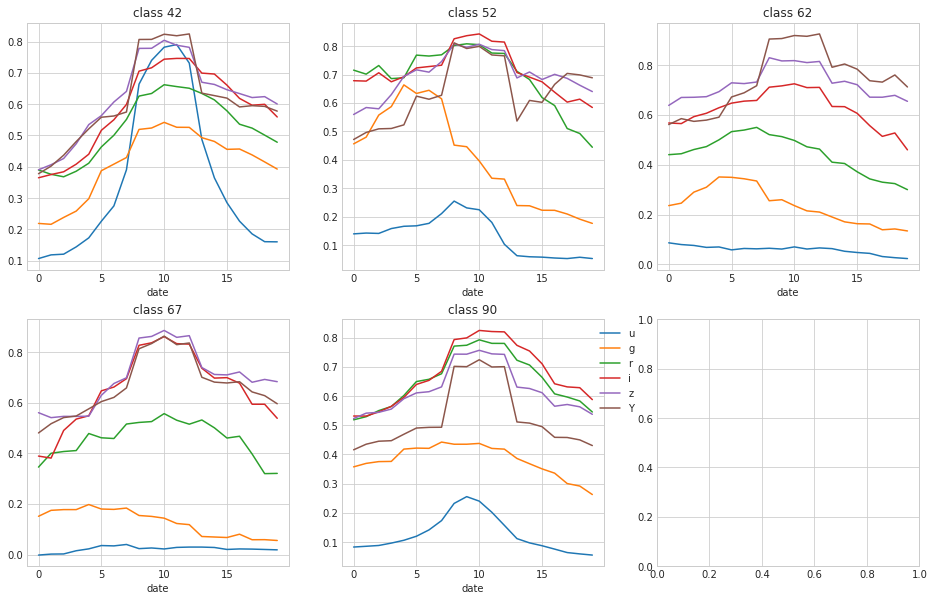

In [16]:
f, ax = plt.subplots(2, 3, figsize=(16, 10))
plt_temp(42, ax[0, 0]) 
plt_temp(52, ax[0, 1]), 
plt_temp(62, ax[0, 2]), 
plt_temp(67, ax[1, 0]), 
plt_temp(90, ax[1, 1], 1)
# plt.tight_layout()